# Advanced Data & Prediction Drift Monitoring (PSI + KS)

This notebook implements:
- Population Stability Index (PSI)
- Kolmogorov–Smirnov (KS) test
- Prediction (score) drift monitoring

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


In [2]:
# Load Refrence (Train) & Current (Production) Data
df = pd.read_csv('../data/features_train.csv')

TARGET = 'isFraud'
x = df.drop(columns=[TARGET])
y = df[TARGET]

In [3]:
# Simulate Time-Based Split 
reference_data = x.sample(frac=0.7, random_state=42)
current_data = x.drop(reference_data.index)

In [6]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

le = LabelEncoder()

# Convert to string
reference_data[col] = reference_data[col].astype(str)
current_data[col] = current_data[col].astype(str)

# Fit on reference
le.fit(reference_data[col])

# Handle unseen labels
current_data[col] = current_data[col].apply(
    lambda x: x if x in le.classes_ else "UNKNOWN"
)

# Add UNKNOWN to encoder classes
le.classes_ = np.append(le.classes_, "UNKNOWN")

# Transform
reference_data[col] = le.transform(reference_data[col])
current_data[col] = le.transform(current_data[col])


In [7]:
# Population Stability Index (PSI)

# PSI Function 
def calculate_psi(expected, actual, bins=10):
    expected = np.array(expected)
    actual = np.array(actual)
    
    breakpoints = np.percentile(expected, np.linspace(0, 100, bins + 1))
    
    expected_counts = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_counts = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    
    psi = np.sum(
        (actual_counts - expected_counts) *
        np.log((actual_counts + 1e-6) / (expected_counts + 1e-6))
    )
    
    return psi


In [8]:
# Compute PSI for Key Features
important_features = [
    "TransactionAmt",
    "card_tx_count_1h",
    "time_since_last_card_tx",
    "amount_zscore"
]


In [9]:
psi_results = {}

for col in important_features:
    psi_results[col] = calculate_psi(
        reference_data[col],
        current_data[col]
    )

psi_df = pd.DataFrame.from_dict(
    psi_results, orient="index", columns=["PSI"]
)

psi_df


,PSI
TransactionAmt,0.000035
card_tx_count_1h,0.000021
time_since_last_card_tx,0.000098
amount_zscore,0.000003


### PSI Interpretation

- PSI < 0.10 → No drift
- 0.10 ≤ PSI < 0.25 → Moderate drift (monitor)
- PSI ≥ 0.25 → Significant drift (action required)


All PSI values are extremely small (<0.0001) → almost no shift from training to test 

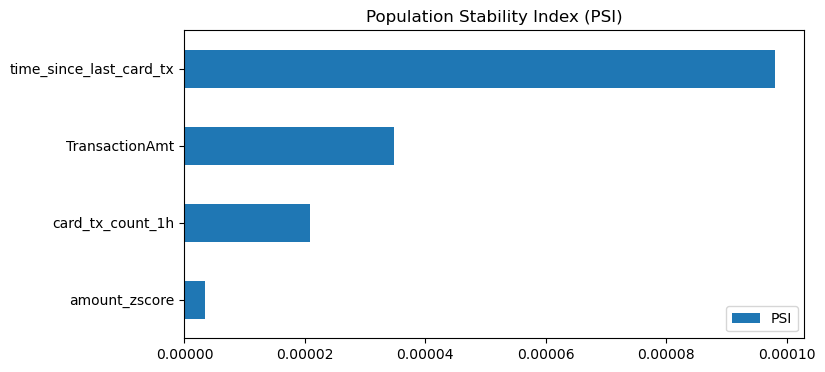

In [10]:
# PSI Visualization 
psi_df.sort_values("PSI").plot(
    kind="barh",
    figsize=(8, 4),
    title="Population Stability Index (PSI)"
)
plt.show()


In [11]:
# KS Test 
ks_results = {}

for col in important_features:
    ks_stat, p_value = ks_2samp(
        reference_data[col],
        current_data[col]
    )
    ks_results[col] = {
        "KS_statistic": ks_stat,
        "p_value": p_value
    }

ks_df = pd.DataFrame(ks_results).T
ks_df


,KS_statistic,p_value
TransactionAmt,0.001809,0.811233
card_tx_count_1h,0.001806,0.812511
time_since_last_card_tx,0.002265,0.547187
amount_zscore,NaN,NaN


### KS Test Interpretation

- p-value < 0.05 → Statistically significant drift
- p-value ≥ 0.05 → No strong evidence of drift

KS tests indicate no statistically significant feature-level drift. Core transactional behavior remains stable. KS test was not applicable for amount_zscore due to insufficient variance in the monitoring window


In [15]:
# Prediction (Score) Drift
import joblib 

model = joblib.load('../Model/xgb_model.pkl')

# For both reference and current data
for df in [reference_data, current_data]:
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype('category')


ref_scores = model.predict_proba(reference_data)[:, 1]
cur_scores = model.predict_proba(current_data)[:, 1]

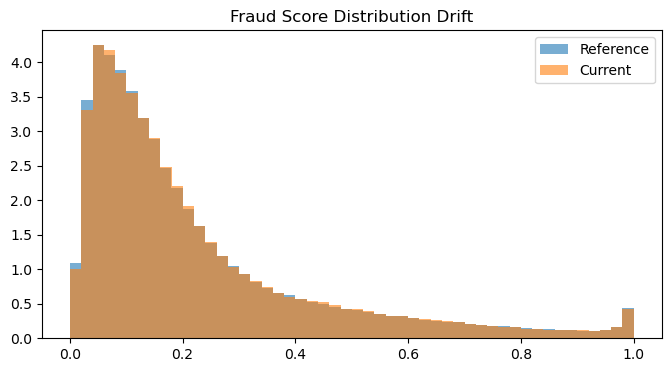

In [16]:
# Score Distribution Plot 
plt.figure(figsize=(8, 4))
plt.hist(ref_scores, bins=50, alpha=0.6, label="Reference", density=True)
plt.hist(cur_scores, bins=50, alpha=0.6, label="Current", density=True)
plt.title("Fraud Score Distribution Drift")
plt.legend()
plt.show()


In [17]:
# KS Test in Scores
ks_stat, p_value = ks_2samp(ref_scores, cur_scores)

ks_stat, p_value


(np.float64(0.006121919082937799), np.float64(0.00018291539058471964))

### Drift Alert Rules

Trigger investigation if:
- Any key feature PSI ≥ 0.25
- OR score KS p-value < 0.01
- OR sustained increase in fraud FN rate

Actions:
- Data quality check
- Feature review
- Model retraining if drift persists


### Drift Monitoring Summary

- PSI detects population changes
- KS test confirms statistical significance
- Score drift ensures model behavior stability

This monitoring framework ensures long-term model reliability,
supports regulatory requirements, and enables proactive retraining.
